In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import pathlib
import os
# import tensorflowjs as tfjs
import matplotlib.pyplot as plt

from os.path import isfile, join
from struct import unpack

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

2023-02-21 16:28:10.517951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 16:28:10.679461: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 16:28:11.324693: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/home/posa/.conda/envs/ada/lib/
2023-02-21 16:28:11.324785: W ten

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Utility functions

These utility functions allows you to verify the integrity of a JPEG image.

In [3]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}
    
class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break

In [4]:
def isjpg(filename):
    try:
        image = JPEG(filename)
        image.decode()
        return True
    except:
        return False

### Step 0: Splitting data

In this step we need to split data to use some of it for the pre-trained model, and some of it for the fine-tuning in Disco (collaborative training).

We first remove all corrupted files from the initial dataset.

In [5]:
corrupted_files = pd.read_csv('./datadir/flickr_images_not_found.csv')['Filename'].values.tolist()
corrupted_files[:10]

['52397186039_e44c51fb5a_c.jpg',
 '52391250327_dcf980999c_c.jpg',
 '52350582378_2d400c5c70_c.jpg',
 '52372316864_ea97e254ec_c.jpg',
 '52405987345_148d854e9a_c.jpg',
 '19411062_e909cca163_c.jpg',
 '355377768_dcaa39cfd9_c.jpg',
 '355377041_39028ffd44_c.jpg',
 '355376832_795282cc15_c.jpg',
 '355376619_0f6a33da25_c.jpg']

In [6]:
df = pd.read_csv('./datadir/flickr_images_label.csv')[['Filename', 'Label']]
df = df[~df['Filename'].isin(corrupted_files)]
df

,Filename,Label
0,52403510017_b159459831_c.jpg,74
1,52404304094_3f0f451201_c.jpg,74
2,52403933171_c8899cf42c_c.jpg,26
3,52403382762_e5422eb713_c.jpg,117
4,52404082559_bf74eb9571_c.jpg,61
...,...,...
307946,14390879470_1d3fbf98a0_c.jpg,112
307947,14390930389_7ec65f84b7_c.jpg,20
307948,14577529815_1c1d7db1b9_c.jpg,20
307949,14576737782_c67f221215_c.jpg,57


We split the data taking 60% of data for the pre-trained model, 20% of data for the fine-tuned model and 20% for testing the model

In [7]:
data_pretrained = df.sample(frac=0.93, random_state=123)
rest_data = df.drop(data_pretrained.index)

data_finetune = rest_data.sample(frac=0.75, random_state=123)
data_test = rest_data.drop(data_finetune.index)

In [8]:
data_pretrained

,Filename,Label
198456,7275169050_e6084df581_c.jpg,48
116116,4285507869_207f52e2cb_c.jpg,94
229621,8410123889_84fe0bb0db_c.jpg,79
46091,2068894099_6d589a8564_c.jpg,73
139980,5040911214_4caa6173d3_c.jpg,85
...,...,...
45081,2021845887_13e379029b_c.jpg,107
105438,3930899920_7be09b7986_c.jpg,41
268529,8464823955_9fafa170fb_c.jpg,34
11884,52412718889_217f1f37cf_c.jpg,67


In [9]:
data_finetune_array = []
N_AGENTS = 3

for i in range(N_AGENTS):
    new_split = data_finetune.sample(frac=(1/(N_AGENTS-i)), random_state=123)
    data_finetune = data_finetune.drop(new_split.index)
    data_finetune_array.append(new_split)

In [10]:
data_finetune_array[0]

,Filename,Label
115560,4262786098_a3d5793282_c.jpg,109
267026,8381998698_e616d8ed80_c.jpg,45
171816,6096217727_bd79e8e9f8_c.jpg,33
15712,31057799_d25e34753f_c.jpg,16
161846,5820872448_4a984e919d_c.jpg,13
...,...,...
260602,9929343473_db5298aafe_c.jpg,84
215483,8007681507_02ce88324c_c.jpg,1
39516,1233636565_01f13b58fc_c.jpg,117
35526,659655089_69d4dd5205_c.jpg,125


In [11]:
data_finetune_array[1]

,Filename,Label
182183,6555890893_c0437d9f14_c.jpg,26
208246,7751421252_2e89242687_c.jpg,23
205440,7638020034_01557480d0_c.jpg,67
262665,10273617663_9d5077441a_c.jpg,7
81411,3157408126_9a5cae2cd0_c.jpg,112
...,...,...
21193,241322255_e9eb3f7dd9_c.jpg,34
42918,1596446049_5a0e817f59_c.jpg,26
274822,9373820918_13f7386459_c.jpg,114
298892,13896726671_82a0d0af78_c.jpg,117


In [12]:
data_finetune_array[2]

,Filename,Label
25843,358963022_eb9fe8ec36_c.jpg,103
161937,5824339486_8e4c2a2016_c.jpg,114
94938,3633180895_d87183de77_c.jpg,112
18535,146374326_6f9c226bb1_c.jpg,113
174184,6169010666_fe24f45158_c.jpg,112
...,...,...
284589,11369558196_ab41ec6736_c.jpg,18
188864,6791901164_d3cb6297e0_c.jpg,59
187023,6917541097_a9eeb531cf_c.jpg,112
40619,1382436809_acdbdf442b_c.jpg,24


In [13]:
data_test

,Filename,Label
44,52401319872_e0160ab68b_c.jpg,109
175,52401599456_ca4136ce53_c.jpg,10
262,52400287130_6d7bd830dc_c.jpg,30
282,52399496983_3eff7bd46a_c.jpg,71
289,52399056335_c6fa113085_c.jpg,6
...,...,...
307870,14391863717_cc1d7fe519_c.jpg,63
307876,14574928451_117464f86e_c.jpg,1
307889,14577063232_a419640be8_c.jpg,20
307916,14391164749_c296a4ddef_c.jpg,1


We need to create as many subfolders as the number of classes, and copy images from ./datadir/flickr_images folder to ./datadir/flickr_images_training/{class} for each class. 
For instance, for 2 classes we should have:

- ./datadir/flickr_images_label/**0**/img{i}.jpg (for each i belonging to class 0)
- ./datadir/flickr_images_label/**1**/img{i}.jpg (for each i belonging to class 1)

In [14]:
def create_directories(current_df, output_folder, subdirs=True):
    # Loading the dataframe containing a map between the imageId and the corresponding label
    data = current_df[['Filename', 'Label']].values.tolist()
    
    # Creating the correct directory structure
    for row in data:
        file_path = join('./datadir/flickr_images/', row[0])
        if isfile(file_path) and isjpg(file_path):
            olddir = f'./datadir/flickr_images/{row[0]}'
            if subdirs:
                newdir = f'./datadir/{output_folder}/{row[1]}/{row[0]}'
            else:
                newdir = f'./datadir/{output_folder}/{row[0]}'

            # Creating directory if it does not exist
            os.makedirs(os.path.dirname(newdir), exist_ok=True)
            # Copying the image
            shutil.copyfile(olddir, newdir)
        else:
            print(f'Error for: {row[0]}')

In [15]:
# Run it only once
# create_directories(data_pretrained, 'flickr_images_training', subdirs=True)
# create_directories(data_test, 'flickr_images_test', subdirs=True)
# for i in range(N_AGENTS):
#    create_directories(data_finetune_array[i], f'flickr_images_disco_training/agent{i}', subdirs=False)
# create_directories(data_test, 'flickr_images_disco_test', subdirs=False)

Exporting all datasets to CSV files

In [17]:
def save_df(current_df, output_filename):
    current_df['Filename'] = current_df['Filename'].apply(lambda s: pathlib.Path(s).stem)
    current_df = current_df.rename(columns={'Filename':'filename', 'Label':'label'})
    current_df.to_csv(f'./datadir/{output_filename}.csv', index=False)

In [18]:
# Run it only once
# save_df(data_pretrained, 'flickr_images_training')
# for i in range(N_AGENTS):
#    save_df(data_finetune_array[i], f'flickr_images_disco_training_{i}')
# save_df(data_finetune, 'flickr_images_disco_training')
# save_df(data_test, 'flickr_images_test')

### Step 1: Loading all images with labels

In this step we need to load images specifying the size, the number of batches and the preprocess steps.

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

We are using `ResNet50V2` model which requires to preprocess input data, and thus we need to call `preprocess_input` when preprocessing.

In [6]:
def preprocess(images, labels):
    return preprocess_input(images), labels

Loading the dataset, and assigning label depending on the directory structure. Also we split the dataset in train and validation, using 20% of images for the validation. 

In [7]:
train_dataset, validation_dataset = image_dataset_from_directory(
    './datadir/flickr_images_training',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    # interpolation='nearest',
    seed=123,
    validation_split=0.2,
    subset='both')

Found 286053 files belonging to 127 classes.
Using 228843 files for training.
Using 57210 files for validation.


2023-02-21 16:29:20.346674: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-21 16:29:20.346729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


In [8]:
test_dataset = image_dataset_from_directory(
    './datadir/flickr_images_test',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    # interpolation='nearest',
    seed=123)

Found 5383 files belonging to 127 classes.


In [9]:
class_names = train_dataset.class_names

# Number of classes
NUM_CLASSES = len(class_names)

Plotting 9 images to have a clue of what the dataset contains

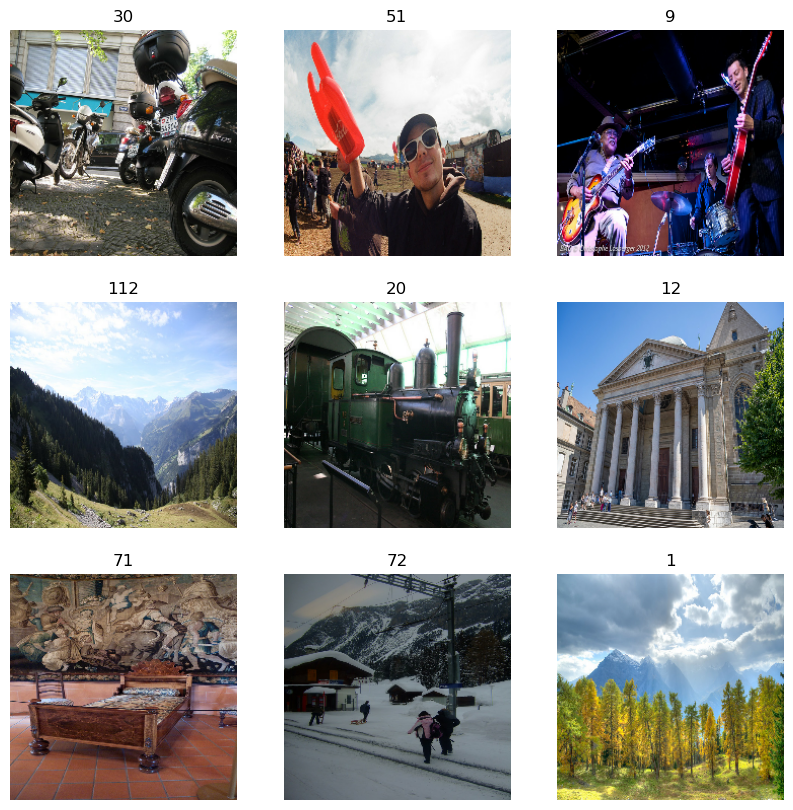

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(np.argmax(labels[i]))
        plt.axis("off")

Also, we use buffered prefetching to load images from disk without having I/O become blocking.

In [11]:
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Step 3: Defining the model (1)

In the first part, we freeze all layers of the base_model (MobileNetV3) setting the `trainable` parameter to `False`, and we add a Dense layer with as many neurons as the number of classes. Since we want the probability for an image to belong to a certain cell in the Switzerland grid, we need the Softmax as activation function.

Moreover, since we will fine-tune MobileNetV3 later, it is important to set `training` to `False` because that forces to use Batch Normalization layers as inference layers even when they are unfrozen. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
inputs = Input(shape=IMG_SHAPE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(*IMG_SHAPE),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(0.1, 0.1),
  tf.keras.layers.RandomBrightness(0.2),
  tf.keras.layers.RandomContrast(0.2)
])

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

9406464/9406464 [==============================] - 0s 0us/step


Specifying the optimizer, the learning rate and the loss function to compile the model.

In [13]:
INITIAL_LEARNING_RATE=0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITIAL_LEARNING_RATE,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 127)               162687    
                                                                 
Total params: 2,420,671
Trainable params: 162,687
Non-trainab

In [14]:
initial_epochs = 20

callback = tf.keras.callbacks.ModelCheckpoint('./saved_models/model_mobilenet_v2.h5',
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset, callbacks=[callback])

Epoch 1/20


2023-02-21 16:30:07.369287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


7152/7152 [==============================] - ETA: 0s - loss: 4.0788 - accuracy: 0.1214
Epoch 1: val_loss improved from inf to 3.72616, saving model to ./saved_models/model_mobilenet_v2.h5
7152/7152 [==============================] - 397s 55ms/step - loss: 4.0788 - accuracy: 0.1214 - val_loss: 3.7262 - val_accuracy: 0.1731
Epoch 2/20
7152/7152 [==============================] - ETA: 0s - loss: 3.7156 - accuracy: 0.1730
Epoch 2: val_loss improved from 3.72616 to 3.60881, saving model to ./saved_models/model_mobilenet_v2.h5
7152/7152 [==============================] - 204s 28ms/step - loss: 3.7156 - accuracy: 0.1730 - val_loss: 3.6088 - val_accuracy: 0.1936
Epoch 3/20
7152/7152 [==============================] - ETA: 0s - loss: 3.6047 - accuracy: 0.1909
Epoch 3: val_loss improved from 3.60881 to 3.55666, saving model to ./saved_models/model_mobilenet_v2.h5
7152/7152 [==============================] - 197s 27ms/step - loss: 3.6047 - accuracy: 0.1909 - val_loss: 3.5567 - val_accuracy: 0.204

Plotting the learning curves

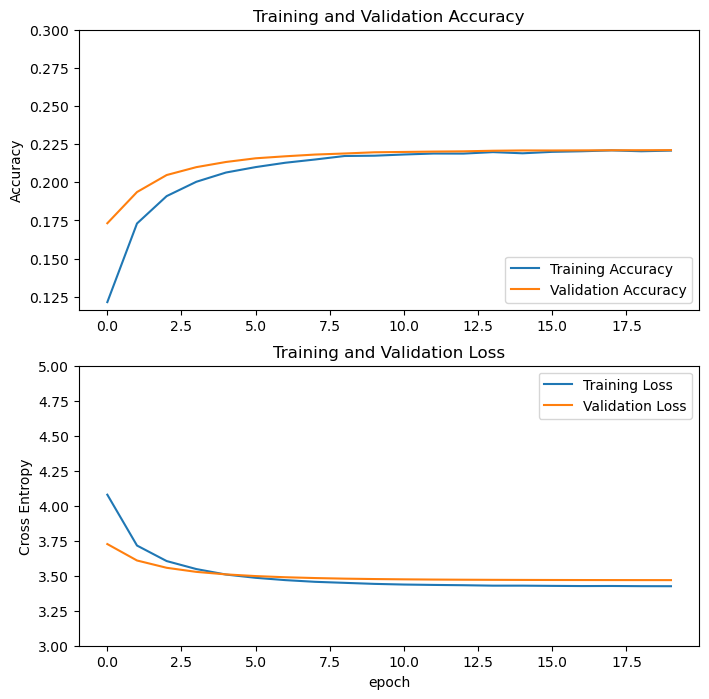

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.3])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([3.0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Step 4: Defining the model (2)

In this step we want to fine-tune the MobileNetV3 making all layers trainable, but keeping a learning rate that is 10 times smaller than the previous one.

In [16]:
base_model.trainable = True

INITIAL_LEARNING_RATE = INITIAL_LEARNING_RATE / 10

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITIAL_LEARNING_RATE,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 127)               162687    
                                                                 
Total params: 2,420,671
Trainable params: 2,386,559
Non-train

In [17]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[callback])

Epoch 20/30
7152/7152 [==============================] - ETA: 0s - loss: 3.3185 - accuracy: 0.2363
Epoch 20: val_loss improved from 3.46861 to 3.25846, saving model to ./saved_models/model_mobilenet_v2.h5
7152/7152 [==============================] - 484s 65ms/step - loss: 3.3185 - accuracy: 0.2363 - val_loss: 3.2585 - val_accuracy: 0.2563
Epoch 21/30
7151/7152 [============================>.] - ETA: 0s - loss: 3.1426 - accuracy: 0.2685
Epoch 21: val_loss improved from 3.25846 to 3.18976, saving model to ./saved_models/model_mobilenet_v2.h5
7152/7152 [==============================] - 467s 65ms/step - loss: 3.1426 - accuracy: 0.2685 - val_loss: 3.1898 - val_accuracy: 0.2699
Epoch 22/30
7151/7152 [============================>.] - ETA: 0s - loss: 3.0574 - accuracy: 0.2841
Epoch 22: val_loss improved from 3.18976 to 3.15712, saving model to ./saved_models/model_mobilenet_v2.h5
7152/7152 [==============================] - 462s 65ms/step - loss: 3.0574 - accuracy: 0.2841 - val_loss: 3.1571 

In [32]:
tfjs.converters.save_keras_model(model, './saved_models/mobilenet_tfjs/') 

Plotting the learning curves

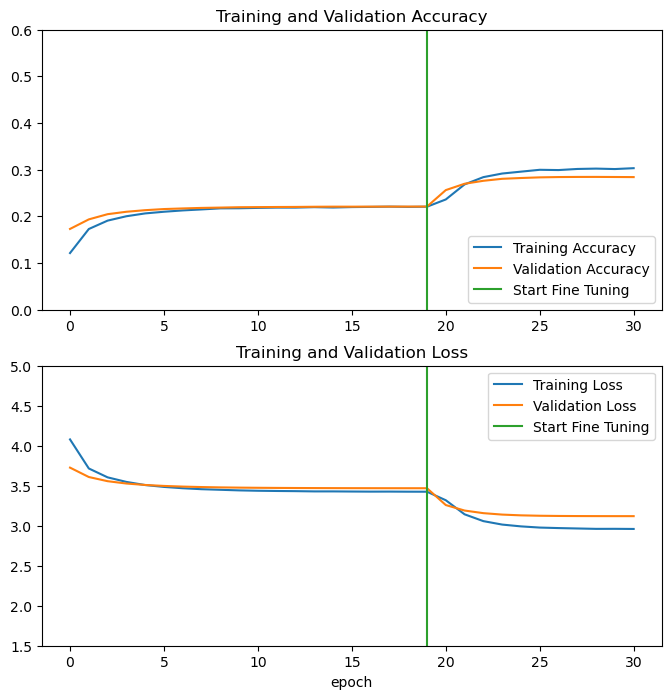

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 0.6])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([1.5, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Step 5: Evaluating the model

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

169/169 [==============================] - 8s 45ms/step - loss: 3.1349 - accuracy: 0.2746
Test accuracy : 0.2745680809020996
